In [105]:
from feature_engine.imputation import MeanMedianImputer
import pickle
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import KFold
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, precision_score, recall_score, accuracy_score, log_loss
from sklearn.preprocessing import label_binarize

from datetime import datetime, timedelta
import holidays

from tqdm import tqdm_notebook, tqdm
import warnings
from sklearn.exceptions import ConvergenceWarning
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

warnings.simplefilter('ignore')
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# seed = 42
# np.random.seed(seed)

In [106]:
def calculate_auuq(y_true, y_pred_proba):
    """
    Функция для вычисления Area Under Uplift Curve (AUUQ).
    
    Параметры:
    y_true (numpy.ndarray или pandas.Series): Истинные ответы, shape (n_samples,)
    y_pred_proba (numpy.ndarray): Предсказанные вероятности, shape (n_samples,)
    
    Возвращает:
    float: Значение AUUQ
    """
    # Сортируем по вероятностям
    sorted_indices = np.argsort(y_pred_proba)[::-1]
    
    try:
        # Используем iloc для позиционного индексирования
        y_true_sorted = y_true.iloc[sorted_indices]
    except KeyError as e:
        print(f"KeyError encountered: {e}")
        return None  # Или обработайте это как нужно
    
    # Вычисляем кумулятивные суммы
    cumulative_gain = np.cumsum(y_true_sorted)
    
    # Вычисляем AUUQ
    total_positive = np.sum(y_true)
    
    if total_positive == 0:  # Проверка на деление на ноль
        return 0.0
    
    auuq = cumulative_gain / total_positive
    
    return np.mean(auuq)

def evaluate_models(models, model_names, X, Y) -> pd.DataFrame:
    """
    Функция для оценки списка моделей по метрикам точности, F1, полноты, точности, ROC AUC, Gini, Log Loss и AUUQ.
    
    Параметры:
    models (list): Список обученных моделей
    model_names (list): Список названий моделей
    X (numpy.ndarray): Набор данных для предсказания, shape (n_samples, n_features)
    Y (numpy.ndarray): Истинные ответы, shape (n_samples,)
    
    Возвращает:
    pandas.DataFrame: Таблица с метриками для каждой модели
    """
    
    if len(models) != len(model_names):
        raise ValueError("Списки моделей и названий моделей должны быть одинаковой длины")
    
    results = []
    
    for model, name in zip(models, model_names):
        y_pred = model.predict(X)
        accuracy = accuracy_score(Y, y_pred)
        f1 = f1_score(Y, y_pred)
        recall = recall_score(Y, y_pred)
        precision = precision_score(Y, y_pred)
        
        # Вычисление предсказания вероятностей для метрик ROC AUC и Gini
        if hasattr(model, "predict_proba"):
            y_proba = model.predict_proba(X)[:, 1]
            roc_auc = roc_auc_score(Y, y_proba)
            gini = 2 * roc_auc - 1
            logloss = log_loss(Y, y_proba)
            auuq = calculate_auuq(pd.Series(Y), y_proba)  # Преобразуем Y в Series для совместимости
        else:
            roc_auc = None
            gini = None
            logloss = None
            auuq = None
        
        results.append({
            'Model': name,
            'Accuracy': accuracy,
            'F1 Score': f1,
            'Recall': recall,
            'Precision': precision,
            'ROC AUC': roc_auc,
            'Gini': gini,
            'Log Loss': logloss,
            'AUUQ': auuq
        })
    
    results_df = pd.DataFrame(results)
    return results_df

In [107]:
def process_dates(df, col_data):
    # Преобразуем серию в формат datetime
    dates = pd.to_datetime(df[col_data])

    # Определяем выходной или рабочий день (0 - рабочий, 1 - выходной)
    df['is_weekend'] = dates.dt.dayofweek >= 5  # Суббота и воскресенье
    df['is_weekend'] = df['is_weekend'].astype(int)  # Преобразуем в 0 и 1

    # Определяем время года (1 - зима, 2 - весна, 3 - лето, 4 - осень)
    df['season'] = np.select(
        [
            (dates.dt.month == 12) | (dates.dt.month <= 2),  # Декабрь, Январь, Февраль
            (dates.dt.month >= 3) & (dates.dt.month <= 5),   # Март, Апрель, Май
            (dates.dt.month >= 6) & (dates.dt.month <= 8),   # Июнь, Июль, Август
            (dates.dt.month >= 9) & (dates.dt.month <= 11)   # Сентябрь, Октябрь, Ноябрь
        ],
        [1, 2, 3, 4]
    )

    # Определяем день недели (1 - понедельник, ..., 7 - воскресенье)
    df['weekday'] = dates.dt.dayofweek + 1

    # Определяем номер месяца
    df['month'] = dates.dt.month

    # Определяем номер недели в месяце
    df['week_of_month'] = ((dates.dt.day - 1) // 7) + 1

    return df

In [108]:
data = pd.read_csv('train_E.csv')
data

,application_1,cc_1,cc_2,cc_3,cc_4,feature_1,mb_1,cc_5,cc_6,feature_2,...,cc_21,application_15,feature_25,feature_26,cc_22,partner_24,application_16,retro_date,successful_utilization,treatment
0,NaN,1.0,Representatives,123.0,Первичная ДК,1,14.0,147000.0,PLT,0.0,...,NaN,0,1.0,0.0,-1.2,1.0,0,2024-07-04,0,1
1,NaN,1.0,Offline,43.0,Airports,0,1.0,120000.0,PLT,0.0,...,1.0,0,1.0,0.0,-1.2,1.0,0,2024-06-06,0,1
2,0.0,1.0,Web,2.0,seo,0,NaN,15000.0,PLT,0.0,...,NaN,0,NaN,0.0,-1.2,1.0,0,2024-07-21,1,1
3,0.0,1.0,MB,2.0,One Click Offer,0,91.0,260000.0,PLT,0.0,...,1.0,0,NaN,1.0,-1.2,1.0,0,2024-05-23,0,1
4,0.0,1.0,Representatives,123.0,Первичная ДК,1,1.0,130000.0,PLT,0.0,...,NaN,0,1.0,0.0,-1.2,1.0,0,2024-06-28,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297245,NaN,1.0,Representatives,123.0,Первичная ДК,1,34.0,95000.0,PLT,0.0,...,NaN,0,1.0,0.0,-1.2,1.0,0,2024-05-13,1,1
297246,NaN,1.0,Representatives,123.0,Первичная ДК,1,1.0,83000.0,PLT,0.0,...,NaN,0,1.0,0.0,-1.2,NaN,0,2024-07-08,0,1
297247,0.0,1.0,Mobile Warm,2.0,TOOS cor clients,0,2.0,170000.0,PLT,0.0,...,1.0,0,NaN,0.0,1.0,1.0,0,2024-06-12,0,1
297248,0.0,1.0,Representatives,123.0,Первичная ДК,1,5.0,15000.0,PLT,0.0,...,0.0,0,1.0,0.0,-1.2,1.0,0,2024-06-02,1,1


In [109]:
test = pd.read_csv('test_E.csv')
test

,application_1,cc_1,cc_2,cc_3,cc_4,feature_1,mb_1,cc_5,cc_6,feature_2,...,bki_46,feature_24,cc_21,application_15,feature_25,feature_26,cc_22,partner_24,application_16,retro_date
0,0.0,1.0,NaN,NaN,NaN,0,6.0,NaN,NaN,0.0,...,373942.00,0.0,1.0,0,0.0,0.0,-1.2,1.0,0,2024-06-18
1,0.0,1.0,NaN,NaN,NaN,0,45.0,NaN,NaN,0.0,...,0.00,0.0,0.0,0,0.0,1.0,-1.2,1.0,0,2024-05-09
2,0.0,1.0,MB,2.0,Heavy xsell,0,13.0,299000.0,PLT,0.0,...,9724333.00,NaN,NaN,0,NaN,0.0,-1.2,1.0,0,2024-05-30
3,0.0,1.0,Representatives,123.0,SIM,1,158.0,140000.0,PLT,0.0,...,0.00,0.0,NaN,0,1.0,0.0,-1.2,1.0,0,2024-05-27
4,0.0,1.0,Representatives,123.0,Первичная ДК,0,36.0,170000.0,PLT,0.0,...,2237284.00,0.0,0.0,0,1.0,0.0,-1.2,1.0,0,2024-06-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74308,NaN,1.0,Representatives,123.0,Multitask,1,NaN,15000.0,PLT,0.0,...,2834099.00,0.0,NaN,0,1.0,0.0,-1.2,1.0,0,2024-05-15
74309,0.0,1.0,Representatives,123.0,Первичная ДК,1,12.0,95000.0,PLT,0.0,...,145886.00,NaN,NaN,0,NaN,0.0,-1.2,1.0,0,2024-07-10
74310,0.0,NaN,PreApprove (Mobile Applicants),2.0,Other,0,5.0,15000.0,PLT,0.0,...,5896358.00,0.0,0.0,1,0.0,1.0,-1.2,1.0,1,2024-06-27
74311,0.0,1.0,Representatives,123.0,Перевыпуск ДК,1,52.0,70000.0,PLT,0.0,...,5339.00,0.0,NaN,0,1.0,0.0,-1.2,1.0,0,2024-06-10


In [110]:
data.isna().sum()

application_1             115128
cc_1                       18235
cc_2                       10479
cc_3                       10479
cc_4                       10482
                           ...  
partner_24                 40468
application_16                 0
retro_date                     0
successful_utilization         0
treatment                      0
Length: 152, dtype: int64

In [111]:
test.isna().sum()

application_1     28716
cc_1               4549
cc_2               2586
cc_3               2586
cc_4               2586
                  ...  
feature_26          765
cc_22               706
partner_24        10173
application_16        0
retro_date            0
Length: 150, dtype: int64

In [112]:
nan_par_nums, nana_par_obj = [], []


for i in data.isnull().sum().items():
    if 0 < i[-1] and data[i[0]].dtype != object:
        nan_par_nums.append(i[0])
    if 0 < i[-1] and data[i[0]].dtype == object:
        nana_par_obj.append(i[0])

for i in test.isnull().sum().items():
    if 0 < i[-1] and test[i[0]].dtype != object:
        nan_par_nums.append(i[0])
    if 0 < i[-1] and test[i[0]].dtype == object:
        nana_par_obj.append(i[0])

In [113]:
for i in nan_par_nums:
    test[i] = test[i].fillna(test[i].mean())
    data[i] = data[i].fillna(data[i].mean())
for i in nana_par_obj:
    test[i] = test[i].fillna(test[i].mode()[0])
    data[i] = data[i].fillna(test[i].mode()[0])

In [114]:
obj_dt = [i for i in data.columns if data[i].dtype == object]
len(obj_dt)

4

cc_2
cc_2
Representatives                   212565
MB                                 24975
PreApprove (Mobile Applicants)     16500
Mobile Warm                        14573
Web                                13095
Offline                             7591
BAF (Приведи друга)                 5191
Down-sell                           2752
Mobile Cold                            5
Other                                  3
Name: count, dtype: int64
['Representatives' 'Offline' 'Web' 'MB' 'Down-sell' 'Mobile Warm'
 'PreApprove (Mobile Applicants)' 'BAF (Приведи друга)' 'Mobile Cold'
 'Other']
10


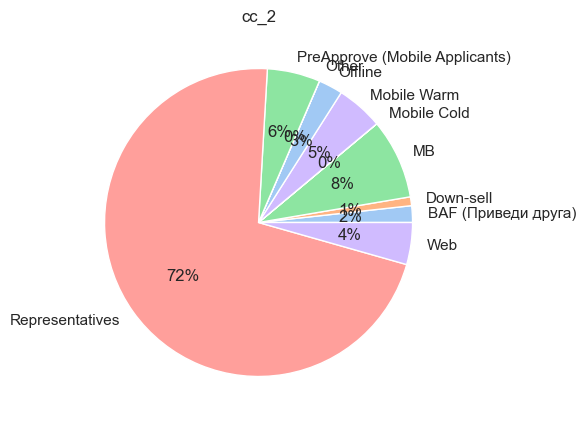


cc_4
cc_4
Первичная ДК       129549
Перевыпуск ДК       29989
Multitask           15941
One Click Offer      9183
Heavy                8413
                    ...  
smm                    11
afterfilling           10
Internet                7
Cold                    5
Installment             1
Name: count, Length: 75, dtype: int64
['Первичная ДК' 'Airports' 'seo' 'One Click Offer' 'Multitask'
 'Перевыпуск ДК' 'Cash Loan' 'Other' 'Установка приложения' 'SIM'
 'Доп.карта ДК' 'TOOS cor clients' 'Другое ДК' 'Heavy' 'affilate'
 'context' 'CCR Rescore (PA)' 'Heavy xsell' 'Страхование' 'Junior ДК'
 'Фейк встречи POS' 'TOOS afterfilling' 'TOOS other' 'Сразу полные'
 'LON Rescore (PA)' 'display' 'xsell_income_call_new' 'Rosbank'
 'COR Clients (PA)' 'pos_tcb_online' 'Инвестиции' 'Light'
 'POS Rescore (PA)' 'TOOS pos_trigger' 'other int' 'Phone' 'SME' 'sms'
 'Direct Car Loan' 'Partners' 'web_lk_organic' 'кошелек'
 'CC Attrition (PA)' 'cpa-bloggers' 'Own Retail' 'INV Clients (PA)'
 'TOOS cl_trig

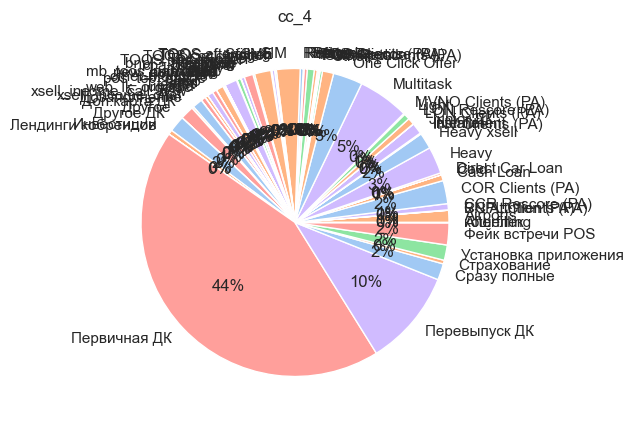


cc_6
cc_6
PLT    293395
AAR      3122
TDC       512
S7C       118
AGC        29
LKC        28
ALC        23
LMC        14
SCB         6
AAC         2
NON         1
Name: count, dtype: int64
['PLT' 'AAR' 'TDC' 'S7C' 'LKC' 'ALC' 'LMC' 'AGC' 'SCB' 'NON' 'AAC']
11


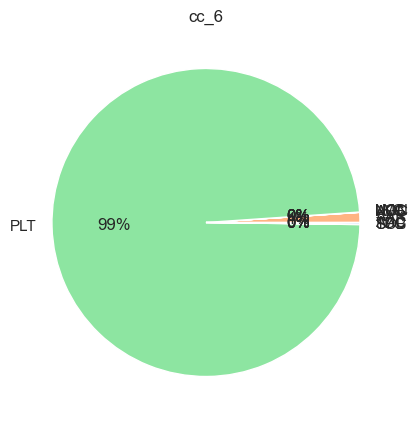


retro_date
retro_date
2024-05-05    5020
2024-05-09    4623
2024-05-06    4466
2024-04-29    4427
2024-06-06    4408
              ... 
2024-07-23    2137
2024-07-09    2093
2024-07-10    1876
2024-07-24    1830
2024-07-17    1825
Name: count, Length: 90, dtype: int64
['2024-07-04' '2024-06-06' '2024-07-21' '2024-05-23' '2024-06-28'
 '2024-06-29' '2024-06-21' '2024-06-09' '2024-06-14' '2024-06-08'
 '2024-05-03' '2024-06-17' '2024-07-18' '2024-05-27' '2024-05-15'
 '2024-06-20' '2024-05-09' '2024-05-01' '2024-05-10' '2024-05-21'
 '2024-05-07' '2024-06-25' '2024-07-15' '2024-06-24' '2024-07-22'
 '2024-05-17' '2024-07-11' '2024-07-03' '2024-06-30' '2024-05-12'
 '2024-06-04' '2024-05-30' '2024-05-24' '2024-07-25' '2024-06-13'
 '2024-05-14' '2024-07-09' '2024-06-16' '2024-04-30' '2024-05-04'
 '2024-06-27' '2024-05-18' '2024-05-08' '2024-07-08' '2024-07-16'
 '2024-06-11' '2024-07-01' '2024-05-31' '2024-05-06' '2024-04-29'
 '2024-07-07' '2024-06-22' '2024-07-19' '2024-06-03' '2024-05-02'
 '20

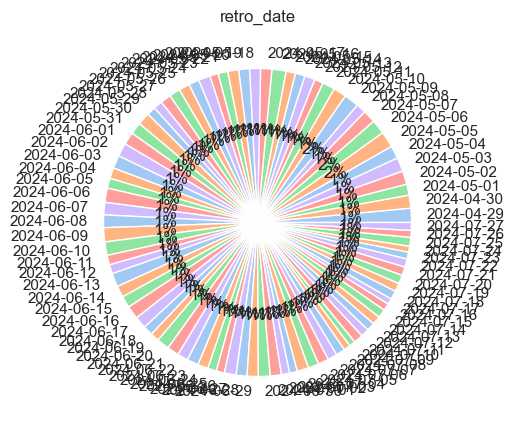

In [115]:
for elem in obj_dt:
    print(elem)
    print(data[elem].value_counts())
    print(data[elem].unique())
    print(len(data[elem].unique()))
    sns.set(rc={'figure.figsize': (5, 5)})
    colors = sns.color_palette('pastel')[0:5]
    labels = sorted(data[elem].map(str).unique())
    dt = np.array([len(data[data[elem] == i]) for i in labels])
    plt.pie(dt, labels=labels, colors=colors, autopct='%.0f%%')
    plt.title(elem)
    plt.show()
    print()

In [116]:
# data = data.drop(columns=['cc_6'])

In [117]:
# data = process_dates(data, 'retro_date')
# test = process_dates(test, 'retro_date')

data = data.drop(columns=['retro_date'])

In [118]:
for i in data.columns:
    if data[i].nunique() < 5:
        print(data[i].unique(), data[i].nunique())
        print(data[i].value_counts())
        print()

[1.] 1
cc_1
1.0    297250
Name: count, dtype: int64

[1 0] 2
feature_1
1    170378
0    126872
Name: count, dtype: int64

[1.] 1
feature_6
1.0    297250
Name: count, dtype: int64

[   0 1890  590  990] 4
cc_10
0       227238
590      64090
1890      5212
990        710
Name: count, dtype: int64

[0 1] 2
cc_11
0    167411
1    129839
Name: count, dtype: int64

[0 1] 2
cc_12
0    167411
1    129839
Name: count, dtype: int64

[1.        0.7758051 0.       ] 3
feature_9
1.000000    188291
0.775805     54546
0.000000     54413
Name: count, dtype: int64

[0.         0.14565479 1.        ] 3
feature_13
0.000000    207353
0.145655     54546
1.000000     35351
Name: count, dtype: int64

[0.         0.20397839 1.        ] 3
bki_19
0.000000    211171
1.000000     54112
0.203978     31967
Name: count, dtype: int64

[0 1] 2
cc_15
0    227176
1     70074
Name: count, dtype: int64

[1.         0.         0.2        0.61350854] 4
feature_17
1.000000    180463
0.000000    113583
0.613509      3051
0.20

In [119]:
# data = data.drop(columns=['feature_6', 'cc_1'])

In [120]:
test = test[data.drop(columns=['successful_utilization', 'treatment']).columns]

In [121]:
# data = pd.get_dummies(data, columns=['cc_4', 'cc_2'], dtype=int)
# test = pd.get_dummies(test, columns=['cc_4', 'cc_2'], dtype=int)

data = data[['successful_utilization', 'treatment'] + [i for i in data.columns.tolist() if i in test.columns.tolist()]]

In [151]:
X = data.drop(columns=['successful_utilization'])
Y = data['successful_utilization']

X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, random_state=42, test_size=0.2)

In [152]:
cat = CatBoostClassifier(iterations=1024, learning_rate=0.1, random_state=42, verbose=500, eval_metric='AUC')
cat.fit(X_train, Y_train, eval_set=(X_valid, Y_valid), use_best_model=True, cat_features=['cc_6', 'cc_4', 'cc_2'])
# cat.fit(X, Y)
print('CatBoostClassifier')

0:	test: 0.6071991	best: 0.6071991 (0)	total: 153ms	remaining: 2m 36s
500:	test: 0.7384479	best: 0.7385041 (493)	total: 2m 18s	remaining: 2m 24s
1000:	test: 0.7382938	best: 0.7388579 (758)	total: 5m 18s	remaining: 7.33s
1023:	test: 0.7381659	best: 0.7388579 (758)	total: 5m 28s	remaining: 0us

bestTest = 0.7388579223
bestIteration = 758

Shrink model to first 759 iterations.
CatBoostClassifier


In [153]:
evaluate_models(
    models=[cat],
    model_names=['CatBoostClassifier'],
    X=X_valid,
    Y=Y_valid
)

,Model,Accuracy,F1 Score,Recall,Precision,ROC AUC,Gini,Log Loss,AUUQ
0,CatBoostClassifier,0.773877,0.282619,0.184774,0.600726,0.738858,0.477716,0.481045,0.681287


In [154]:
submit = pd.read_csv('sub_E.csv').drop(columns=['Unnamed: 0'])

test['treatment'] = 1
test = test[X.columns]
submit['successful_utilization_1'] = cat.predict_proba(test)[:, 1]

test['treatment'] = 0
test = test[X.columns]
submit['successful_utilization_0'] = cat.predict_proba(test)[:, 1]

submit['successful_utilization'] = abs(submit['successful_utilization_1'] - submit['successful_utilization_0'])
submit = submit.drop(columns=['successful_utilization_1', 'successful_utilization_0'])

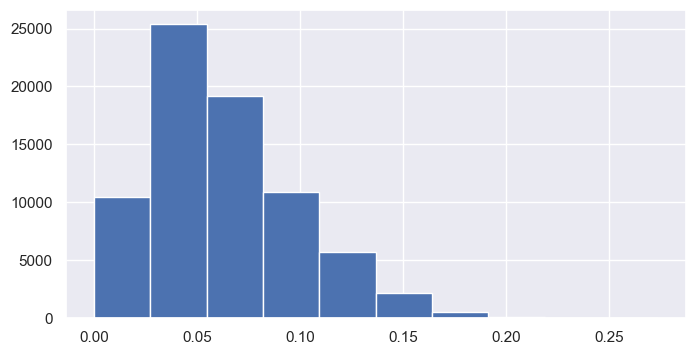

In [155]:
submit['successful_utilization'].hist(figsize=(8, 4));
submit.to_csv('я_помню_твою_маму.csv')